# 📊 Strategic Patient Risk Stratification & Readmission Predictive Modeling  
## Vitality Health Network

---

### 🏥 Project Overview

**Project Name:** Vitality Health Data Analysis  
**Author(s):** *[Your Name / Team Name]*  
**Date:** *2026-01-06*  
**Course / Organization:** *ITS 2122 – Python for Data Science & AI*  
**Institution / Client:** *Vitality Health Network (VHN)*  

---

### 📘 Notebook Purpose

This Jupyter Notebook documents the **end-to-end data analysis pipeline** developed for the Vitality Health Network project.  
The primary goal is to **analyze clinical patterns and identify risk factors contributing to hospital readmissions**, supporting data-driven decision-making.

The notebook includes the following stages:

- 📥 Data loading and initial inspection  
- 🧹 Data cleaning and preprocessing  
- 📊 Exploratory Data Analysis (EDA)  
- 🧠 Feature engineering for predictive modeling  
- 🗂️ Merging and mapping categorical clinical IDs  
- 💾 Export of the final cleaned and enriched dataset  

---

### 🗃️ Data Sources

- **Raw Clinical Data:** `diabetic_data.csv`  
- **Clinical Code Mappings:** `IDs_mapping.csv`  

---

### ⚙️ Data Processing Notes

- Missing values (`?`) are standardized to `NaN`  
- Patients with expired discharge dispositions are removed  
- The `weight` column is dropped due to >90% missing values  
- Clinical ID fields (admission type, discharge disposition, admission source) are mapped to human-readable descriptions  
- Duplicate records are removed while preserving valid multiple encounters  

---

### 🛠️ Tools & Technologies

- **Programming Language:** Python 3  
- **Libraries:** Pandas, NumPy  
- **Environment:** Jupyter Notebook  

---

> *This notebook serves as the analytical foundation for subsequent modeling and risk stratification tasks, including the development of a clinical complexity score to identify high-risk patients.*


# Phase 1: Diabetic Data Cleaning Notebook
This notebook performs Phase 1 of the data cleaning process for the diabetic dataset. It loads the raw data, handles missing values, removes expired patients, merges ID descriptions, and validates the final cleaned dataset.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

### 1️. Load the raw diabetic data

In [2]:
# File paths (adjust if needed)
RAW_DATA_PATH = '../data/raw/diabetic_data.csv'
ID_MAP_PATH = '../data/raw/IDs_mapping.csv'
CLEAN_DATA_PATH = '../data/processed/diabetic_data_clean.csv'
ENRICH_DATA_PATH = '../data/processed/diabetic_data_enriched.csv'

# Load raw data, converting '?' to NaN
df = pd.read_csv(RAW_DATA_PATH, na_values=['?'])
df.head()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\3454739263.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH, na_values=['?'])


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### 2️. Drop columns due to excessive missing values

In [3]:
# Function to drop columns with high percentage of missing values
def drop_columns_if_missing(df, threshold=0.9, columns=None):
    """Drop columns exceeding threshold of missing values"""
    if columns is None:
        columns = df.columns
    cols_to_drop = [col for col in columns if df[col].isna().mean() > threshold]
    if cols_to_drop:
        print(f"Dropping columns due to missing values > {threshold*100}%: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
    return df

df = drop_columns_if_missing(df, threshold=0.9)

Dropping columns due to missing values > 90.0%: ['weight', 'max_glu_serum']


### 3️. Remove expired patients

In [4]:
expired_ids = [11,19,20,21]  # Expired discharge_disposition_id
df = df[~df['discharge_disposition_id'].isin(expired_ids)]
print(f'Remaining rows after removing expired patients: {len(df)}')

Remaining rows after removing expired patients: 100114


### 4️. Load and merge ID mappings

In [5]:
# ---------------- 4️⃣ Load and merge ID mappings ---------------- #

# Function to parse the IDs_mapping.csv into separate DataFrames
def load_mapping_sections(mapping_csv_path):
    """
    Parse IDs_mapping.csv which contains multiple mapping tables
    separated by header rows and blank lines.
    Returns three DataFrames: admission_type, discharge_disposition, admission_source
    """
    sections = {
        "admission_type_id": [],
        "discharge_disposition_id": [],
        "admission_source_id": []
    }

    current_section = None

    with open(mapping_csv_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Detect section headers
            if line.startswith("admission_type_id"):
                current_section = "admission_type_id"
                continue
            elif line.startswith("discharge_disposition_id"):
                current_section = "discharge_disposition_id"
                continue
            elif line.startswith("admission_source_id"):
                current_section = "admission_source_id"
                continue

            # Skip malformed lines
            if "," not in line or current_section is None:
                continue

            id_val, desc = line.split(",", 1)
            if id_val.isdigit():
                sections[current_section].append(
                    {"id": int(id_val), "description": desc.strip('"')}
                )

    # Convert each section to DataFrame
    admission_type_df = pd.DataFrame(sections["admission_type_id"])
    discharge_df = pd.DataFrame(sections["discharge_disposition_id"])
    admission_source_df = pd.DataFrame(sections["admission_source_id"])

    return admission_type_df, discharge_df, admission_source_df



In [6]:
# Load mapping CSV
admission_type_map, discharge_map, admission_source_map = load_mapping_sections(ID_MAP_PATH)


### Note: The mapping CSV contains multiple sections. For simplicity, we'll create separate mappings manually based on the earlier CSV content.

In [7]:
# Function to map numeric IDs to descriptions
def merge_id_descriptions_safe(df, mapping_df, id_col, new_col_name):
    """
    Maps numeric IDs to descriptions safely without creating extra columns.
    """
    mapping_dict = mapping_df.set_index('id')['description'].to_dict()
    df[new_col_name] = df[id_col].map(mapping_dict)
    print(f"Mapped '{id_col}' to '{new_col_name}'")
    return df

# Merge all three mappings into the main DataFrame
df = merge_id_descriptions_safe(df, admission_type_map, 'admission_type_id', 'admission_type_desc')
df = merge_id_descriptions_safe(df, discharge_map, 'discharge_disposition_id', 'discharge_desc')
df = merge_id_descriptions_safe(df, admission_source_map, 'admission_source_id', 'admission_source_desc')

# Check results
df.head()


Mapped 'admission_type_id' to 'admission_type_desc'
Mapped 'discharge_disposition_id' to 'discharge_desc'
Mapped 'admission_source_id' to 'admission_source_desc'


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,...,No,No,No,No,No,No,NO,NULL,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


### 5️. Remove duplicate rows

In [8]:
initial_count = len(df)
df = df.drop_duplicates()
print(f'Removed {initial_count - len(df)} duplicate rows.')

Removed 0 duplicate rows.


### 6️. Validate cleaned dataset

In [9]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 100114 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              100114 non-null  int64 
 1   patient_nbr               100114 non-null  int64 
 2   race                      97875 non-null   object
 3   gender                    100114 non-null  object
 4   age                       100114 non-null  object
 5   admission_type_id         100114 non-null  int64 
 6   discharge_disposition_id  100114 non-null  int64 
 7   admission_source_id       100114 non-null  int64 
 8   time_in_hospital          100114 non-null  int64 
 9   payer_code                60523 non-null   object
 10  medical_specialty         50985 non-null   object
 11  num_lab_procedures        100114 non-null  int64 
 12  num_procedures            100114 non-null  int64 
 13  num_medications           100114 non-null  int64 
 14  number_ou

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc
count,1.001140e+05,1.001140e+05,97875,100114,100114,100114.000000,100114.000000,100114.000000,100114.000000,60523,...,100114,100114,100114,100114,100114,100114,100114,100114,100114,100114
unique,NaN,NaN,5,3,10,NaN,NaN,NaN,NaN,17,...,2,2,2,2,2,2,3,8,23,17
top,NaN,NaN,Caucasian,Female,[70-80),NaN,NaN,NaN,NaN,MC,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
freq,NaN,NaN,74845,53861,25562,NaN,NaN,NaN,NaN,31739,...,100101,100113,100112,100113,53671,77272,53212,52884,60234,56363
mean,1.653032e+08,5.430611e+07,NaN,NaN,NaN,2.028597,3.594622,5.738388,4.389646,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.027194e+08,3.871493e+07,NaN,NaN,NaN,1.446225,5.237490,4.066412,2.974531,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.493462e+07,2.339867e+07,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.524511e+08,4.548078e+07,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.305332e+08,8.755836e+07,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7️. Save cleaned dataset

In [10]:
df.to_csv(CLEAN_DATA_PATH, index=False)
print(f'Saved cleaned dataset to {CLEAN_DATA_PATH}')

Saved cleaned dataset to ../data/processed/diabetic_data_clean.csv


## Cleaning Decisions Summary:
- **Missing values**: Replaced '?' with NaN for proper handling.
- **Weight column**: Dropped due to >90% missing values.
- **Expired patients**: Removed patients with `discharge_disposition_id` 11.
- **ID mappings**: Merged human-readable descriptions for admission type, discharge disposition, and admission source.
- **Duplicates**: Removed duplicate rows to ensure clean data.
- **Validation**: Dataset info and descriptive stats checked post-cleaning.

# Phase 2: Data Enrichment via Web Scraping
## Objective: Contextualize ICD-9 diagnosis codes.

This notebook enriches the diabetic dataset by adding human-readable descriptions for the top 20 most frequent ICD-9 diagnosis codes.

### 1. Load Data

In [11]:
df = pd.read_csv(CLEAN_DATA_PATH)
print(f"Dataset loaded: {df.shape}")

Dataset loaded: (100114, 51)


C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\2694771486.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CLEAN_DATA_PATH)


### 2. Identify Top 20 Most Frequent Diagnoses

In [12]:
top_20_codes = df['diag_1'].value_counts().head(20).index.tolist()
print("Top 20 ICD-9 Codes:", top_20_codes)

Top 20 ICD-9 Codes: ['428', '414', '786', '410', '486', '427', '491', '715', '682', '780', '434', '996', '276', '250.8', '599', '38', '584', 'V57', '250.6', '820']


### 3. Scrape Descriptions

In [13]:
print("Starting scraper (this may take 20+ seconds)...")

# Function to scrape ICD-9 descriptions
def get_icd9_description(code):
    """
    Fetches the ICD-9 description for a given code from http://icd9.chrisendres.com/
    SEARCH URL: http://icd9.chrisendres.com/index.php?action=search&srchtext={code}
    """
    url = f"http://icd9.chrisendres.com/index.php?action=search&srchtext={code}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Pattern 1: Look for div with class 'dlvl'
            results = soup.find_all('div', class_='dlvl')
            for res in results:
                text = res.get_text(strip=True)
                # The text usually starts with the code
                if text.startswith(str(code)):
                    # Remove the code from the start.
                    # Example: "428 Heart failure" -> "Heart failure"
                    return text[len(str(code)):].strip()

            # Pattern 2: Sometimes it might be in a different structure if it's a sub-code
            # Try to find the exact code followed by text
            # This is a fallback
            
            return None
        else:
            print(f"Failed to fetch {code}: Status {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Error fetching {code}: {e}")
        return None

# Scrape top 20 codes
def scrape_top_codes(codes):
    descriptions = {}
    for code in codes:
        print(f"Scraping code: {code}...")
        desc = get_icd9_description(code)
        if desc:
            print(f"Found: {desc}")
            descriptions[code] = desc
        else:
            print(f"Not Found for {code}")
            descriptions[code] = "Description not found"
    return descriptions

descriptions = scrape_top_codes(top_20_codes)
print("Scraping complete.")

Starting scraper (this may take 20+ seconds)...
Scraping code: 428...
Found: Heart failure
Scraping code: 414...
Found: Other forms of chronic ischemic heart disease
Scraping code: 786...
Found: Symptoms involving respiratory system and other chest symptoms
Scraping code: 410...
Found: Acute myocardial infarction
Scraping code: 486...
Found: Pneumonia, organism unspecified
Scraping code: 427...
Found: Cardiac dysrhythmias
Scraping code: 491...
Found: Chronic bronchitis
Scraping code: 715...
Found: Osteoarthrosis and allied disorders
Scraping code: 682...
Found: Other cellulitis and abscess
Scraping code: 780...
Found: General symptoms
Scraping code: 434...
Found: Occlusion of cerebral arteries
Scraping code: 996...
Found: Complications peculiar to certain specified procedures
Scraping code: 276...
Found: Disorders of fluid, electrolyte, and acid-base balance
Scraping code: 250.8...
Found: Diabetes with other specified manifestations
Scraping code: 599...
Found: Other disorders of ureth

### 4. Integration
Create `Primary_Diagnosis_Desc` column. Map scraped descriptions and label others as "Other".

In [14]:
# Create the new column
df['Primary_Diagnosis_Desc'] = df['diag_1'].map(descriptions)

# Fill missing descriptions (not in top 20 or failed scrape) with "Other"
df['Primary_Diagnosis_Desc'] = df['Primary_Diagnosis_Desc'].fillna('Other')

# Mark everything not in top 20 as Other explicitly if map didn't do it (it would be NaN)
# (Logic above handles it by filling NaNs)

# Verify
print(df[['diag_1', 'Primary_Diagnosis_Desc']].head(10))
print(df['Primary_Diagnosis_Desc'].value_counts().head())

   diag_1                             Primary_Diagnosis_Desc
0  250.83                                              Other
1     276  Disorders of fluid, electrolyte, and acid-base...
2     648                                              Other
3       8                                              Other
4     197                                              Other
5     414      Other forms of chronic ischemic heart disease
6     414      Other forms of chronic ischemic heart disease
7     428                                      Heart failure
8     398                                              Other
9     434                     Occlusion of cerebral arteries
Primary_Diagnosis_Desc
Other                                                             49276
Heart failure                                                      6735
Other forms of chronic ischemic heart disease                      6555
Symptoms involving respiratory system and other chest symptoms     4016
Acute myocardial i

### 5. Save Data

In [15]:
os.makedirs(os.path.dirname(ENRICH_DATA_PATH), exist_ok=True) 
df.to_csv(ENRICH_DATA_PATH, index=False)
print(f"Enriched data saved to {ENRICH_DATA_PATH}")

Enriched data saved to ../data/processed/diabetic_data_enriched.csv


# Phase 3: Exploratory Data Analysis (EDA)

## Objective
Uncover the hidden trends and correlations driving readmissions. We will inspect the target variable imbalance, demographic disparities, medication efficacy, and operational metrics.

In [16]:

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv(ENRICH_DATA_PATH)

# Display first few rows and columns to verify
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (100114, 52)


C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\2195351582.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ENRICH_DATA_PATH)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc,Primary_Diagnosis_Desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,...,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,...,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,"Disorders of fluid, electrolyte, and acid-base..."
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other


### 1. The Readmission Landscape
**Insight**: Identify the class imbalance. Is the <30 group (the HRRP penalty group) a minority?

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\707628970.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')


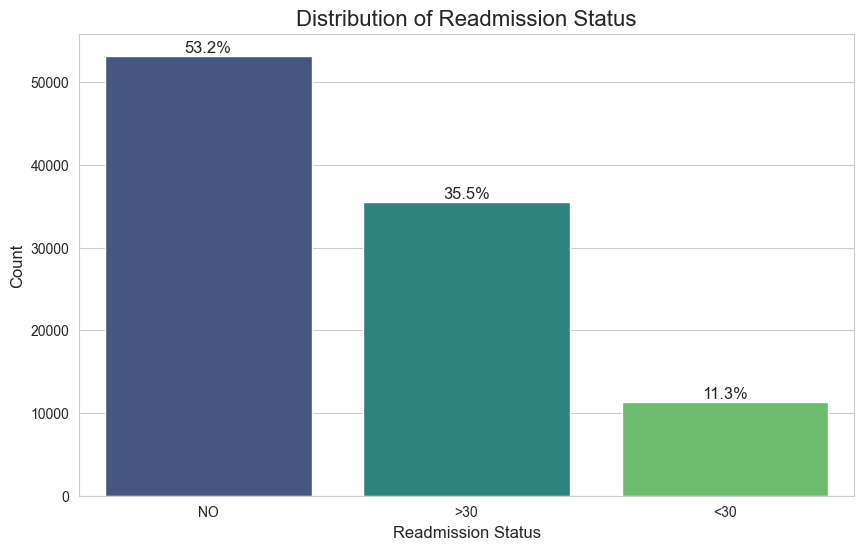

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')
plt.title('Distribution of Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

### 2. Demographic Profiling
**Goal**: Visualize age distribution and analyze readmission rates by race and gender.

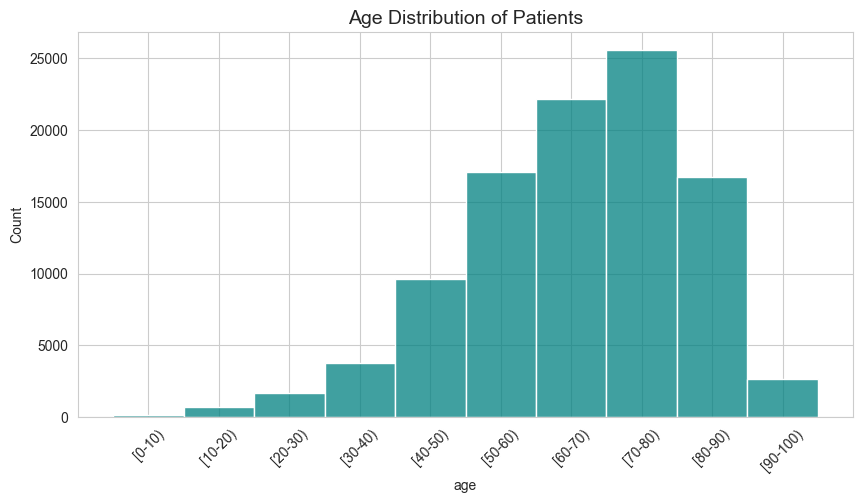

In [18]:
# --- 1. AGE DISTRIBUTION ---
plt.figure(figsize=(10, 5))
sns.histplot(df['age'].sort_values(), bins=10, kde=False, color='teal')
plt.title('Age Distribution of Patients', fontsize=14)
plt.xticks(rotation=45)
plt.show()

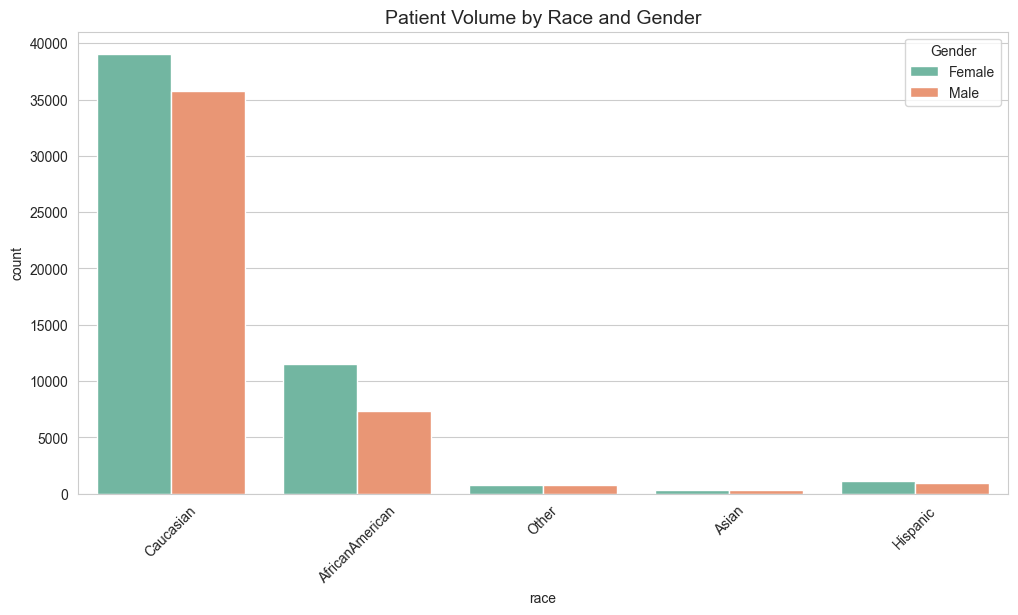

In [19]:
# --- 2. READMISSION BY RACE AND GENDER ---
# We want to see the intersectionality. Are Black women readmitted more than White men?

# Filter out 'Unknown' or invalid gender/race entries for cleaner plots if necessary
clean_subset = df[(df['race'] != '?') & (df['gender'] != 'Unknown/Invalid')]

plt.figure(figsize=(12, 6))
# We normalize to get rates (proportions) instead of raw counts, or use countplot with hue
# A countplot shows raw numbers, which is good for volume.
sns.countplot(x='race', hue='gender', data=clean_subset, palette='Set2')
plt.title('Patient Volume by Race and Gender', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

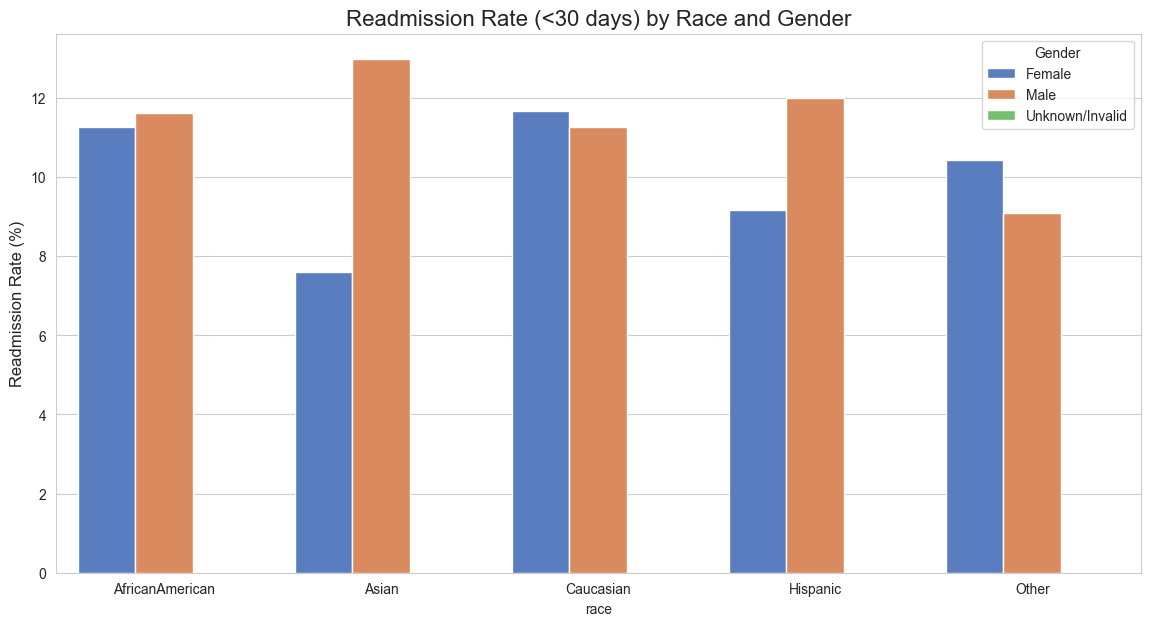

In [20]:
# Readmission rates by Race and Gender
# Helper to calculate rate of '<30' readmission
def calculate_readmission_rate(x):
    return (x == '<30').mean() * 100

race_gender_readm = df.groupby(['race', 'gender'])['readmitted'].apply(calculate_readmission_rate).reset_index()
race_gender_readm.rename(columns={'readmitted': 'Readmission Rate (<30) %'}, inplace=True)

plt.figure(figsize=(14, 7))
sns.barplot(x='race', y='Readmission Rate (<30) %', hue='gender', data=race_gender_readm, palette='muted')
plt.title('Readmission Rate (<30 days) by Race and Gender', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.legend(title='Gender')
plt.show()

### 3. Medication Efficacy Analysis
**Goal**: Compare readmission rates for Insulin vs Oral Meds vs No Meds.
Also check if dosage changes correlate with readmission.

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\3382720002.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=med_readm.index, y=med_readm.values, palette='Blues_d')


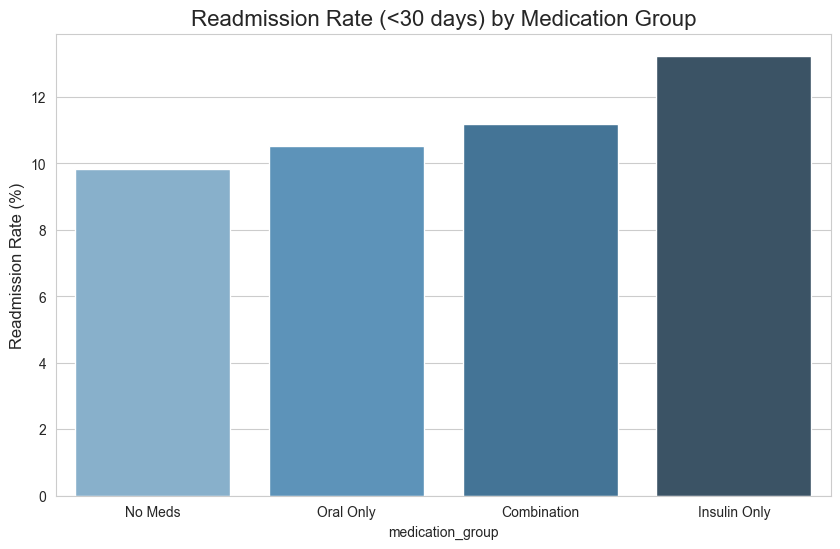

In [21]:
# Identify medication columns
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
            'tolazamide', 'examide', 'citoglipton', 'insulin', 
            'glyburide-metformin', 'glipizide-metformin', 
            'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

# Check which actually exist in df
existing_med_cols = [c for c in med_cols if c in df.columns]
oral_med_cols = [c for c in existing_med_cols if c != 'insulin']

def classify_meds(row):
    has_insulin = row['insulin'] != 'No'
    has_oral = any(row[col] != 'No' for col in oral_med_cols)
    
    if has_insulin and not has_oral:
        return 'Insulin Only'
    elif has_oral and not has_insulin:
        return 'Oral Only'
    elif has_insulin and has_oral:
        return 'Combination'
    else:
        return 'No Meds'

df['medication_group'] = df.apply(classify_meds, axis=1)

# Visualize Readmission Rate by Med Group
med_readm = df.groupby('medication_group')['readmitted'].apply(calculate_readmission_rate).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=med_readm.index, y=med_readm.values, palette='Blues_d')
plt.title('Readmission Rate (<30 days) by Medication Group', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\3903293722.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change', y='readmitted', data=change_readm, palette='Set2')


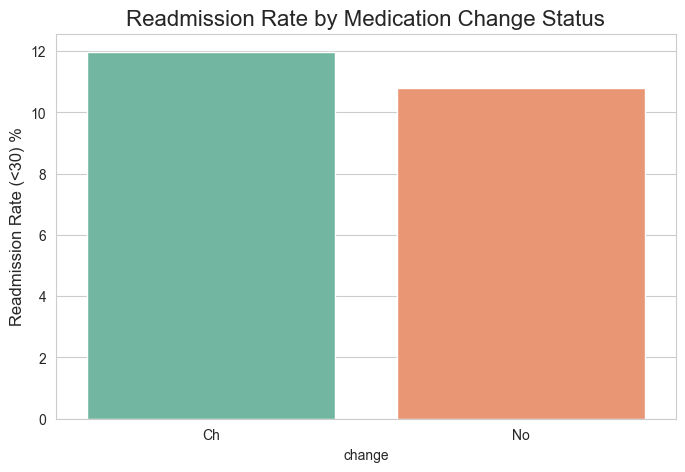

In [22]:
# Analysis of 'change' column
plt.figure(figsize=(8, 5))
# Calculate rates
change_readm = df.groupby('change')['readmitted'].apply(calculate_readmission_rate).reset_index()
sns.barplot(x='change', y='readmitted', data=change_readm, palette='Set2')
plt.title('Readmission Rate by Medication Change Status', fontsize=16)
plt.ylabel('Readmission Rate (<30) %', fontsize=12)
plt.show()

### 4. Operational Metrics
**Goal**: Analyze time in hospital, lab procedures, and discharge disposition.

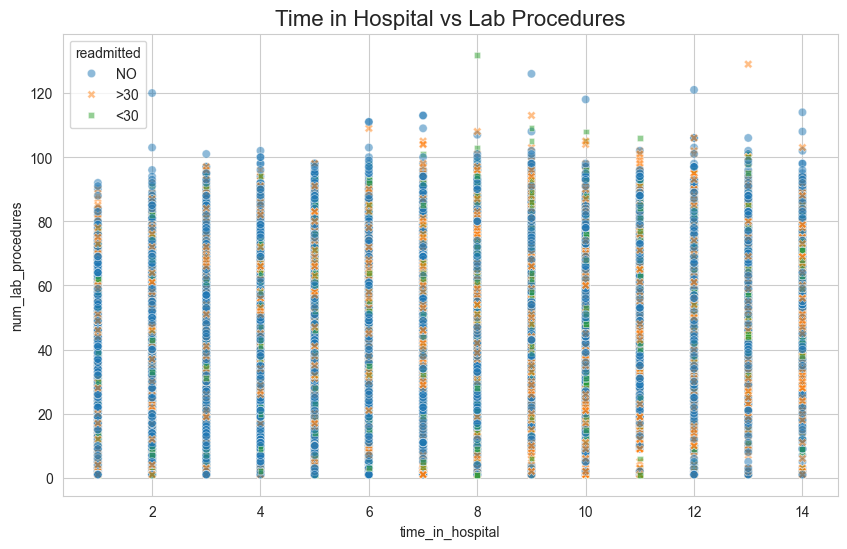

In [23]:
# Relationship between time_in_hospital and num_lab_procedures
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_in_hospital', y='num_lab_procedures', hue='readmitted', data=df, alpha=0.5, style='readmitted')
plt.title('Time in Hospital vs Lab Procedures', fontsize=16)
plt.show()

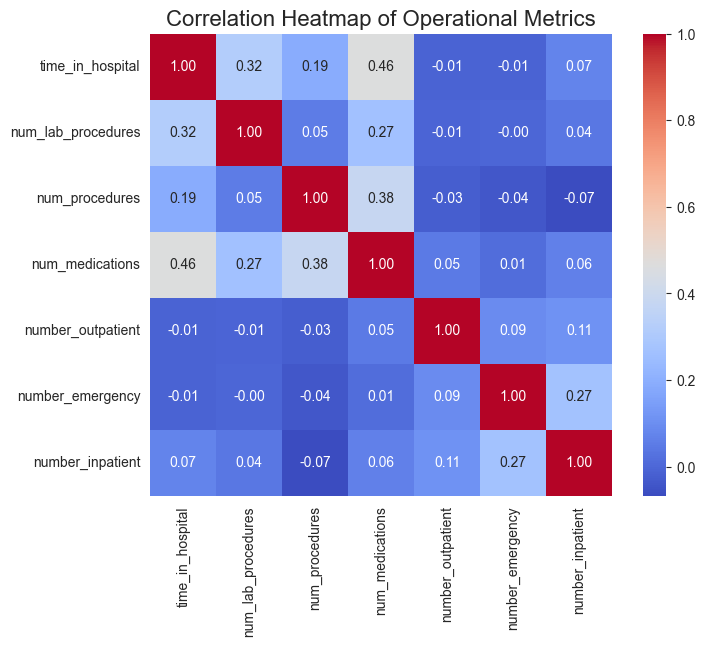

In [24]:
# Correlation Heatmap
cols_to_corr = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                  'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Operational Metrics', fontsize=16)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\2256906818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Pastel1')


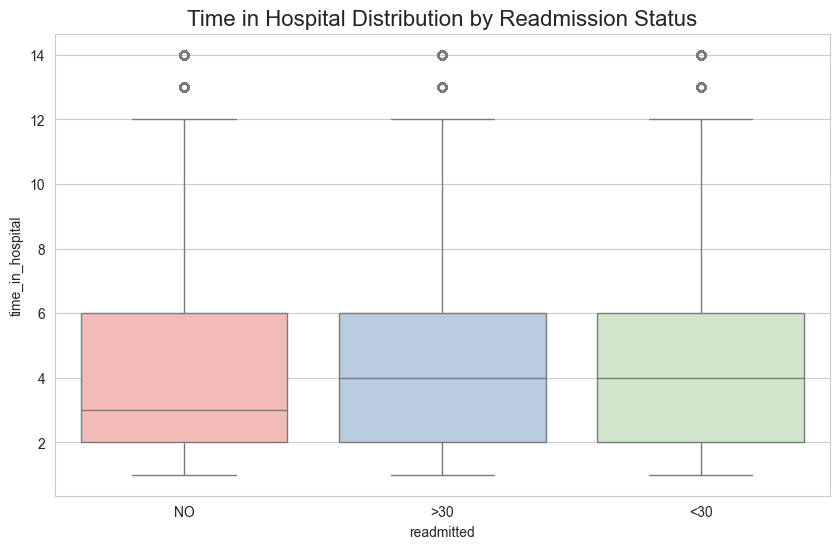

In [25]:
# Box plots of time_in_hospital by readmitted status
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Pastel1')
plt.title('Time in Hospital Distribution by Readmission Status', fontsize=16)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\1775945624.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dis_readm.index, y=dis_readm.values, palette='rocket')


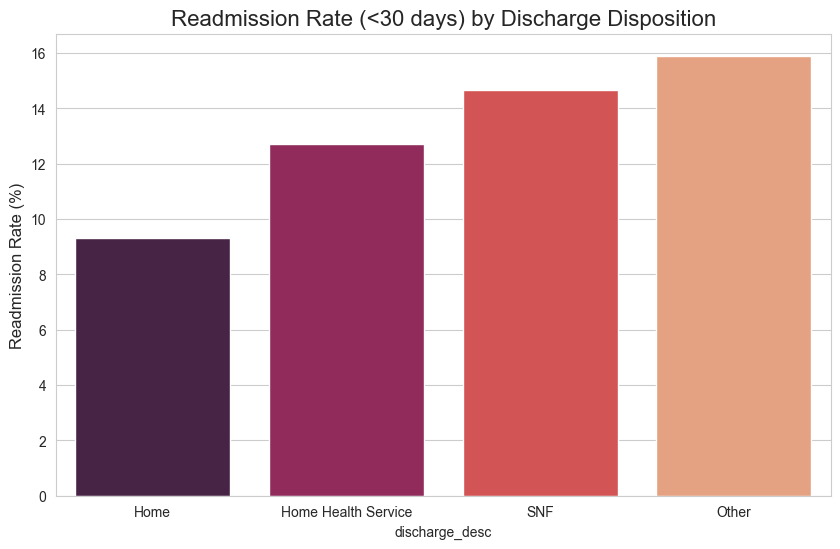

In [26]:
# Discharge Disposition Analysis
# Mapping IDs for clarity
discharge_mapping = {
    1: 'Home',
    3: 'SNF',  # Skilled Nursing Facility
    6: 'Home Health Service',
    # Add others if relevant or frequent
}

# Create a readable column (filling others with ID)
df['discharge_desc'] = df['discharge_disposition_id'].map(discharge_mapping).fillna('Other')

# Filter for top categories to avoid clutter
top_discharges = df['discharge_desc'].value_counts().head(5).index
df_discharge = df[df['discharge_desc'].isin(top_discharges)]

dis_readm = df_discharge.groupby('discharge_desc')['readmitted'].apply(calculate_readmission_rate).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=dis_readm.index, y=dis_readm.values, palette='rocket')
plt.title('Readmission Rate (<30 days) by Discharge Disposition', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.show()

# Phase 4: Vitality Complexity Index (VCI) Implementation

## Objective
Translate clinical intuition into a programmable algorithm by implementing a variant of the LACE Index (Length of Stay, Acuity, Comorbidities, Emergency Visits).

## Scoring Logic
1. **L - Length of Stay Score**:
    * time_in_hospital < 1 day: 0 points
    * 1–4 days: 1 point
    * 5–13 days: 4 points
    * >= 14 days: 7 points
2. **A - Acuity of Admission Score**:
    * admission_type_id 1 (Emergency) or 7 (Trauma Center): 3 points
    * Others: 0 points
3. **C - Comorbidity Burden Score (Proxy)**:
    * number_diagnoses < 4: 0 points
    * 4–7 diagnoses: 3 points
    * >= 8 diagnoses: 5 points
4. **E - Emergency Visit Intensity Score**:
    * number_emergency 0: 0 points
    * 1–4 visits: 3 points
    * > 4 visits: 5 points

**Calculation**: VCI_Score = L + A + C + E

## Stratification
* **Low Risk**: VCI < 7
* **Medium Risk**: VCI 7–10
* **High Risk**: VCI > 10

In [27]:
# Load the dataset
try:
    df = pd.read_csv(ENRICH_DATA_PATH)
    print("Dataset loaded successfully.")
except FileNotFoundError:

    print("Enriched data not found, checking raw data or alternative paths...")
    df = pd.read_csv(CLEAN_DATA_PATH)

df.head()

Dataset loaded successfully.


C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\1734197794.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ENRICH_DATA_PATH)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc,Primary_Diagnosis_Desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,...,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,...,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,"Disorders of fluid, electrolyte, and acid-base..."
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other


In [28]:
# 1. L - Length of Stay Score
def calculate_L_score(days):
    if days < 1:
        return 0
    elif 1 <= days <= 4:
        return 1
    elif 5 <= days <= 13:
        return 4
    else: # >= 14
        return 7

df['L_Score'] = df['time_in_hospital'].apply(calculate_L_score)
print("L Score calculated.")

L Score calculated.


In [29]:
# 2. A - Acuity of Admission Score
# Emergency (1) or Trauma Center (7)
def calculate_A_score(admission_id):
    if admission_id in [1, 7]:
        return 3
    else:
        return 0

df['A_Score'] = df['admission_type_id'].apply(calculate_A_score)
print("A Score calculated.")

A Score calculated.


In [30]:
# 3. C - Comorbidity Burden Score (Proxy)
def calculate_C_score(diagnoses_count):
    if diagnoses_count < 4:
        return 0
    elif 4 <= diagnoses_count <= 7:
        return 3
    else: # >= 8
        return 5

df['C_Score'] = df['number_diagnoses'].apply(calculate_C_score)
print("C Score calculated.")

C Score calculated.


In [31]:
# 4. E - Emergency Visit Intensity Score
def calculate_E_score(emergency_visits):
    if emergency_visits == 0:
        return 0
    elif 1 <= emergency_visits <= 4:
        return 3
    else: # > 4
        return 5

df['E_Score'] = df['number_emergency'].apply(calculate_E_score)
print("E Score calculated.")

E Score calculated.


In [32]:
# Calculate Total VCI Score
df['VCI_Score'] = df['L_Score'] + df['A_Score'] + df['C_Score'] + df['E_Score']

# Stratify into Risk Categories
def stratify_risk(score):
    if score < 7:
        return 'Low Risk'
    elif 7 <= score <= 10:
        return 'Medium Risk'
    else: # > 10
        return 'High Risk'

df['Risk_Category'] = df['VCI_Score'].apply(stratify_risk)

# Display distribution
df['Risk_Category'].value_counts()

Risk_Category
Medium Risk    52023
Low Risk       28101
High Risk      19990
Name: count, dtype: int64

In [33]:
# Validation: Readmission Rate (<30) by Risk Category
# Create a binary column for readmitted < 30
df['readmitted_less_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Calculate rates
risk_analysis = df.groupby('Risk_Category')['readmitted_less_30'].mean() * 100

# Reorder for plotting logic
ordered_index = ['Low Risk', 'Medium Risk', 'High Risk']
risk_analysis = risk_analysis.reindex(ordered_index)

print(risk_analysis)

Risk_Category
Low Risk        8.807516
Medium Risk    11.414182
High Risk      14.727364
Name: readmitted_less_30, dtype: float64


C:\Users\Charuka\AppData\Local\Temp\ipykernel_1592\2803526625.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_analysis.index, y=risk_analysis.values, palette='viridis')


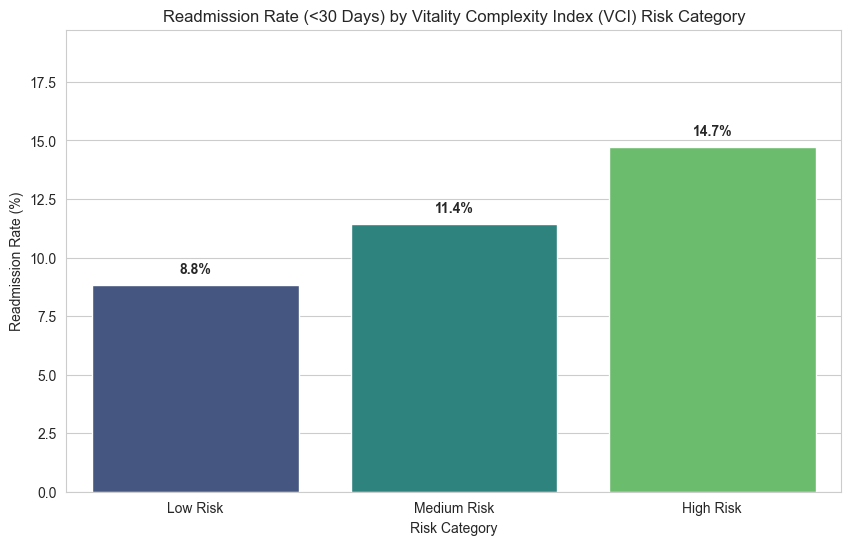

In [34]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=risk_analysis.index, y=risk_analysis.values, palette='viridis')
plt.title('Readmission Rate (<30 Days) by Vitality Complexity Index (VCI) Risk Category')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Risk Category')
plt.ylim(0, max(risk_analysis.values) + 5) # Add some headroom

for i, v in enumerate(risk_analysis.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()